In [1]:
import pandas as pd
import re
import time
import datetime
import pickle
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import scorecard_function
import score_card as sc

In [2]:
def CareerYear(x):
    # 对工作年限进行转换
    x = str(x)
    if x.find('nan') > -1:
        return -1
    elif x.find("10+") > -1:  # 将"10＋years"转换成 11
        return 11
    elif x.find('< 1') > -1:  # 将"< 1 year"转换成 0
        return 0
    else:
        return int(re.sub("\D", "", x))  # 其余数据，去掉"years"并转换成整数


def DescExisting(x):
    # 将desc变量转换成有记录和无记录两种
    if type(x).__name__ == 'float':
        return 'no desc'
    else:
        return 'desc'


def ConvertDateStr(x):
    mth_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10,
                'Nov': 11, 'Dec': 12}
    if str(x) == 'nan':
        return datetime.datetime.fromtimestamp(time.mktime(time.strptime('9900-1', '%Y-%m')))
        # time.mktime 不能读取1970年之前的日期
    else:
        yr = int(x[4:6])
        if yr <= 17:
            yr = 2000 + yr
        else:
            yr = 1900 + yr
        mth = mth_dict[x[:3]]
        return datetime.datetime(yr, mth, 1)


def MonthGap(earlyDate, lateDate):
    if lateDate > earlyDate:
        gap = relativedelta(lateDate, earlyDate)
        yr = gap.years
        mth = gap.months
        return yr * 12 + mth
    else:
        return 0


def MakeupMissing(x):
    if np.isnan(x):
        return -1
    else:
        return x

In [3]:
# 数据预处理
# 1，读入数据
# 2，选择合适的建模样本
# 3，数据集划分成训练集和测试集


folderOfData = './'

allData = pd.read_csv(folderOfData + 'application.csv', header=0, encoding='latin1')
allData['term'] = allData['term'].apply(lambda x: int(x.replace(' months', '')))

# 处理标签：Fully Paid是正常用户；Charged Off是违约用户
allData['y'] = allData['loan_status'].map(lambda x: int(x == 'Charged Off'))

In [4]:
'''
由于存在不同的贷款期限（term），申请评分卡模型评估的违约概率必须要在统一的期限中，且不宜太长，所以选取term＝36months的行本
'''

allData1 = allData.loc[allData.term == 36]

trainData, testData = train_test_split(allData1, test_size=0.4)

# 固化变量
trainDataFile = open(folderOfData + 'trainData.pkl', 'wb+')
pickle.dump(trainData, trainDataFile)
trainDataFile.close()

testDataFile = open(folderOfData + 'testData.pkl', 'wb+')
pickle.dump(testData, testDataFile)
testDataFile.close()


In [5]:
'''
第一步：数据预处理，包括
（1）数据清洗
（2）格式转换
（3）确实值填补
'''

# 将带％的百分比变为浮点数
trainData['int_rate_clean'] = trainData['int_rate'].map(lambda x: float(x.replace('%', '')) / 100)

# 将工作年限进行转化，否则影响排序
trainData['emp_length_clean'] = trainData['emp_length'].map(CareerYear)

# 将desc的缺失作为一种状态，非缺失作为另一种状态
trainData['desc_clean'] = trainData['desc'].map(DescExisting)

# 处理日期。earliest_cr_line的格式不统一，需要统一格式且转换成python的日期
trainData['app_date_clean'] = trainData['issue_d'].map(lambda x: ConvertDateStr(x))
trainData['earliest_cr_line_clean'] = trainData['earliest_cr_line'].map(lambda x: ConvertDateStr(x))

# 处理mths_since_last_delinq。原始值中有0，用－1代替缺失
trainData['mths_since_last_delinq_clean'] = trainData['mths_since_last_delinq'].map(lambda x: MakeupMissing(x))

trainData['mths_since_last_record_clean'] = trainData['mths_since_last_record'].map(lambda x: MakeupMissing(x))

trainData['pub_rec_bankruptcies_clean'] = trainData['pub_rec_bankruptcies'].map(lambda x: MakeupMissing(x))


In [6]:
'''
第二步：变量衍生
'''
# 考虑申请额度与收入的占比
trainData['limit_income'] = trainData.apply(lambda x: x.loan_amnt / x.annual_inc, axis=1)

# 考虑earliest_cr_line到申请日期的跨度，以月份记
trainData['earliest_cr_to_app'] = trainData.apply(lambda x: MonthGap(x.earliest_cr_line_clean, x.app_date_clean),
                                                  axis=1)


In [7]:
# 每个变量缺失率的计算
def missing_cal(df):
    """
    df :数据集
    
    return：每个变量的缺失率
    """
    missing_series = df.isnull().sum()/df.shape[0]
    missing_df = pd.DataFrame(missing_series).reset_index()
    missing_df = missing_df.rename(columns={'index':'col',
                                            0:'missing_pct'})
    missing_df = missing_df.sort_values('missing_pct',ascending=False).reset_index(drop=True)
    return missing_df
missing_cal(trainData)

,col,missing_pct
0,mths_since_last_record,0.925359
1,mths_since_last_delinq,0.643467
2,desc,0.318611
3,emp_length,0.028241
4,pub_rec_bankruptcies,0.023372
5,title,0.000286
6,issue_d,0.000000
7,earliest_cr_line,0.000000
8,y,0.000000
9,int_rate_clean,0.000000


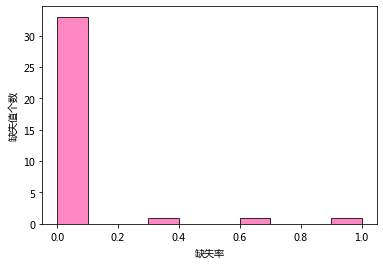

In [8]:
# 变量的缺失分布图
def plot_missing_var(df,plt_size=None):
    """
    df: 数据集
    plt_size :图纸的尺寸
    
    return: 缺失分布图（直方图形式)
    """
    missing_df = missing_cal(df)
    plt.figure(figsize=plt_size)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    x = missing_df['missing_pct']
    plt.hist(x=x,bins=np.arange(0,1.1,0.1),color='hotpink',ec='k',alpha=0.8)
    plt.ylabel('缺失值个数')
    plt.xlabel('缺失率')
    return plt.show()
plot_missing_var(trainData,plt_size=None)

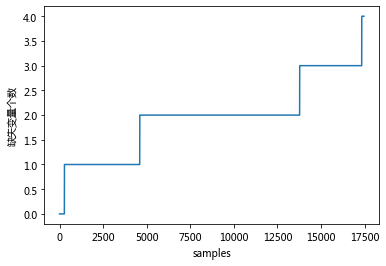

In [9]:
# 单个样本的缺失分布
def plot_missing_user(df,plt_size=None):
    """
    df: 数据集
    plt_size: 图纸的尺寸
    
    return :缺失分布图（折线图形式）
    """
    missing_series = df.isnull().sum(axis=1)
    list_missing_num  = sorted(list(missing_series.values))
    plt.figure(figsize=plt_size)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(range(df.shape[0]),list_missing_num)
    plt.ylabel('缺失变量个数')
    plt.xlabel('samples')
    return plt.show()
plot_missing_user(trainData,plt_size=None)

In [10]:
# 缺失值剔除（单个变量）
def missing_delete_var(df,threshold=None):
    """
    df:数据集
    threshold:缺失率删除的阈值
    
    return :删除缺失后的数据集
    """
    df2 = df.copy()
    missing_df = missing_cal(df)
    missing_col_num = missing_df[missing_df.missing_pct>=threshold].shape[0]
    missing_col = list(missing_df[missing_df.missing_pct>=threshold].col)
    df2 = df2.drop(missing_col,axis=1)
    print('缺失率超过{}的变量个数为{}'.format(threshold,missing_col_num))
    return df2
trainData=missing_delete_var(trainData,threshold=0.3)

缺失率超过0.3的变量个数为3


In [139]:
missing_series = x.isnull().sum(axis=1)
missing_list = list(missing_series)
missing_index_list = []
for i,j in enumerate(missing_list):
    if j>=1:
        missing_index_list.append(i)

In [11]:
# 缺失值剔除（单个样本）
def missing_delete_user(df,threshold=None):
    """
    df:数据集
    threshold:缺失个数删除的阈值
    
    return :删除缺失后的数据集
    """
    df2 = df.copy()
    missing_series = df.isnull().sum(axis=1)
    missing_list = list(missing_series)
    missing_index_list = []
    for i,j in enumerate(missing_list):
        if j>=threshold:
            missing_index_list.append(i)
    df2 = df2[~(df2.index.isin(missing_index_list))]
    print('缺失变量个数在{}以上的用户数有{}个'.format(threshold,len(missing_index_list)))
    return df2
trainData=missing_delete_user(trainData,threshold=1)

缺失变量个数在1以上的用户数有906个


In [12]:
# 缺失值填充（类别型变量）
def fillna_cate_var(df,col_list,fill_type=None):
    """
    df:数据集
    col_list:变量list集合
    fill_type: 填充方式：众数/当做一个类别
    
    return :填充后的数据集
    """
    df2 = df.copy()
    for col in col_list:
        if fill_type=='class':
            df2[col] = df2[col].fillna('unknown')
        if fill_type=='mode':
            df2[col] = df2[col].fillna(df2[col].mode()[0])
    return df2
col_list=list(trainData.columns)
trainData=fillna_cate_var(trainData,col_list,fill_type=None)

In [13]:
# 数值型变量的填充
# 针对缺失率在5%以下的变量用中位数填充
# 缺失率在5%--15%的变量用随机森林填充,可先对缺失率较低的变量先用中位数填充，在用没有缺失的样本来对变量作随机森林填充
# 缺失率超过15%的变量建议当做一个类别
def fillna_num_var(df,col_list,fill_type=None,filled_df=None):
    """
    df:数据集
    col_list:变量list集合
    fill_type:填充方式：中位数/随机森林/当做一个类别
    filled_df :已填充好的数据集，当填充方式为随机森林时 使用
    
    return:已填充好的数据集
    """
    df2 = df.copy()
    for col in col_list:
        if fill_type=='median':
            df2[col] = df2[col].fillna(df2[col].median())
        if fill_type=='class':
            df2[col] = df2[col].fillna(-999)
        if fill_type=='rf':
            rf_df = pd.concat([df2[col],filled_df],axis=1)
            known = rf_df[rf_df[col].notnull()]
            unknown = rf_df[rf_df[col].isnull()]
            x_train = known.drop([col],axis=1)
            y_train = known[col]
            x_pre = unknown.drop([col],axis=1)
            rf = RandomForestRegressor(random_state=0)
            rf.fit(x_train,y_train)
            y_pre = rf.predict(x_pre)
            df2.loc[df2[col].isnull(),col] = y_pre
    return df2
fillna_num_var(trainData,col_list,fill_type=None,filled_df=None)

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,...,int_rate_clean,emp_length_clean,desc_clean,app_date_clean,earliest_cr_line_clean,mths_since_last_delinq_clean,mths_since_last_record_clean,pub_rec_bankruptcies_clean,limit_income,earliest_cr_to_app
30433,30434,6000,36,Fully Paid,13.85%,6 years,RENT,33000.0,Verified,other,...,0.1385,6,no desc,2010-04-01,2005-06-01,39.0,-1.0,0.0,0.181818,58
18925,18926,7000,36,Fully Paid,7.66%,10+ years,RENT,38000.0,Verified,moving,...,0.0766,11,no desc,2011-03-01,1982-06-01,63.0,-1.0,0.0,0.184211,345
33983,33984,5000,36,Charged Off,14.96%,< 1 year,RENT,48000.0,Not Verified,debt_consolidation,...,0.1496,0,desc,2009-11-01,1996-05-01,25.0,-1.0,0.0,0.104167,162
9226,9227,21600,36,Fully Paid,10.59%,10+ years,MORTGAGE,108000.0,Verified,major_purchase,...,0.1059,11,no desc,2011-08-01,1999-10-01,-1.0,-1.0,0.0,0.200000,142
39757,39759,1200,36,Fully Paid,11.54%,< 1 year,RENT,20000.0,Not Verified,credit_card,...,0.1154,0,desc,2007-07-01,2004-05-01,24.0,0.0,-1.0,0.060000,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29349,29350,9000,36,Fully Paid,6.76%,< 1 year,MORTGAGE,79000.0,Not Verified,debt_consolidation,...,0.0676,0,desc,2010-06-01,1998-06-01,-1.0,-1.0,0.0,0.113924,144
7470,7471,10000,36,Fully Paid,7.51%,6 years,MORTGAGE,30000.0,Source Verified,debt_consolidation,...,0.0751,6,desc,2011-09-01,2005-01-01,-1.0,-1.0,0.0,0.333333,80
9319,9320,1500,36,Fully Paid,7.49%,2 years,RENT,32000.0,Not Verified,major_purchase,...,0.0749,2,desc,2011-08-01,1998-06-01,-1.0,-1.0,0.0,0.046875,158
38628,38630,6500,36,Fully Paid,13.87%,6 years,MORTGAGE,105000.0,Not Verified,credit_card,...,0.1387,6,desc,2008-07-01,1994-12-01,10.0,-1.0,0.0,0.061905,163


In [34]:
num_features = ['int_rate_clean', 'emp_length_clean', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_to_app',
                'inq_last_6mths', \
                'mths_since_last_record_clean', 'mths_since_last_delinq_clean', 'open_acc', 'pub_rec', 'total_acc',
                'limit_income', 'earliest_cr_to_app']

cat_features = ['home_ownership', 'verification_status', 'desc_clean', 'purpose', 'zip_code', 'addr_state']
feature_list=num_features+cat_features

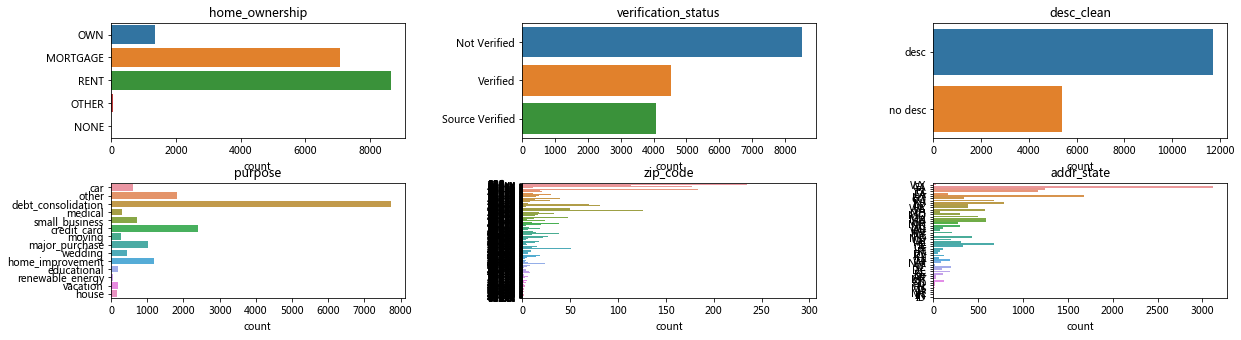

In [35]:
# 类别型变量的分布
def plot_cate_var(df,col_list,hspace=0.4,wspace=0.4,plt_size=None,plt_num=None,x=None,y=None):
    """
    df:数据集
    col_list:变量list集合
    hspace :子图之间的间隔(y轴方向)
    wspace :子图之间的间隔(x轴方向)
    plt_size :图纸的尺寸
    plt_num :子图的数量
    x :子图矩阵中一行子图的数量
    y :子图矩阵中一列子图的数量
    
    return :变量的分布图（柱状图形式）
    """
    plt.figure(figsize=plt_size)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    for i,col in zip(range(1,plt_num+1,1),col_list):
        plt.subplot(x,y,i)
        plt.title(col)
        sns.countplot(data=df,y=col)
        plt.ylabel('')
    return plt.show()
plot_cate_var(trainData,cat_features,hspace=0.4,wspace=0.4,plt_size=(20,8),plt_num=9,x=3,y=3)

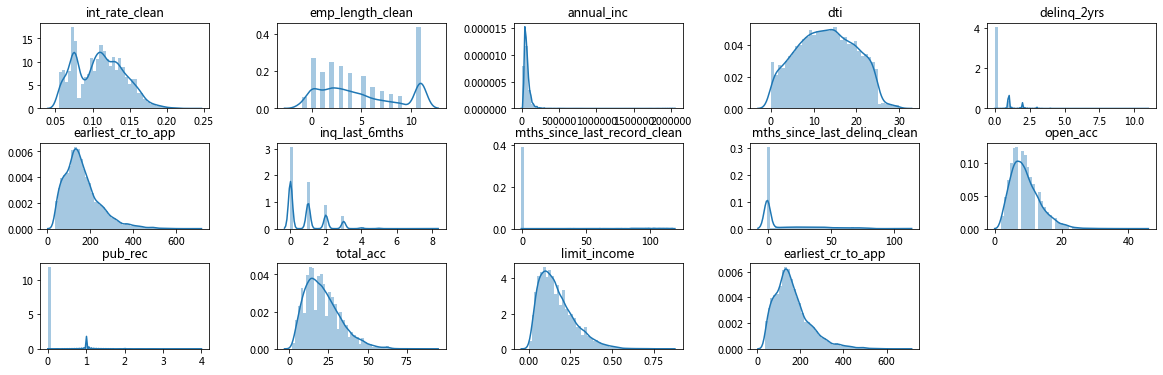

In [16]:
# 数值型变量的分布
def plot_num_col(df,col_list,hspace=0.4,wspace=0.4,plt_type=None,plt_size=None,plt_num=None,x=None,y=None):
    """
    df:数据集
    col_list:变量list集合
    hspace :子图之间的间隔(y轴方向)
    wspace :子图之间的间隔(x轴方向)
    plt_type: 选择直方图/箱线图
    plt_size :图纸的尺寸
    plt_num :子图的数量
    x :子图矩阵中一行子图的数量
    y :子图矩阵中一列子图的数量
    
    return :变量的分布图（箱线图/直方图）
    """
    plt.figure(figsize=plt_size)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    if plt_type=='hist':
        for i,col in zip(range(1,plt_num+1,1),col_list):
            plt.subplot(x,y,i)
            plt.title(col)
            sns.distplot(df[col].dropna())
            plt.xlabel('')
    if plt_type=='box':
        for i,col in zip(range(1,plt_num+1,1),col_list):
            plt.subplot(x,y,i)
            plt.title(col)
            sns.boxplot(data=df,x=col)
            plt.xlabel('')
    return plt.show()
plot_num_col(trainData,num_features,hspace=0.4,plt_type='hist',wspace=0.4,plt_size=(20,6),plt_num=15,x=3,y=5)

In [18]:
trainData['emp_length_clean'].unique()

array([ 4,  8,  0,  5,  2, 11,  6,  9,  7, -1,  3,  1], dtype=int64)

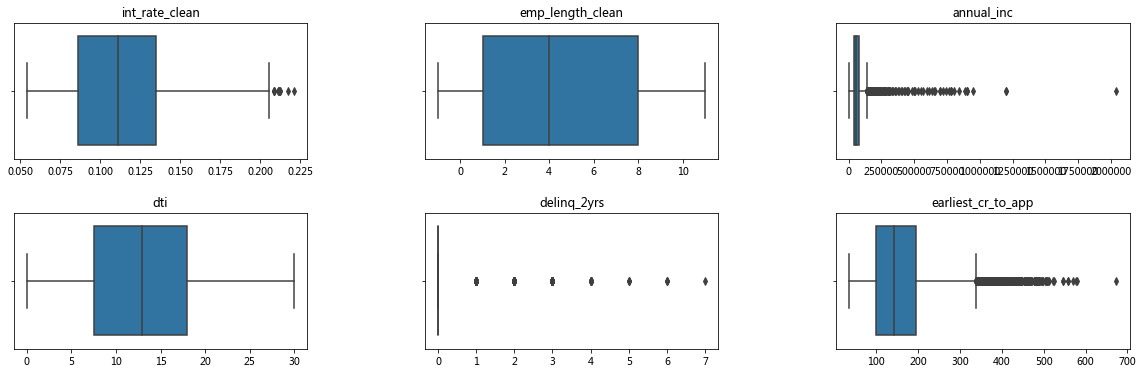

In [64]:
plot_num_col(trainData,num_features,hspace=0.4,plt_type='box',wspace=0.4,plt_size=(20,6),plt_num=6,x=2,y=3)

In [37]:
# 类别型变量的违约率分析
def plot_default_cate(df,col_list,target,hspace=0.4,wspace=0.4,plt_size=None,plt_num=None,x=None,y=None):
    """
    df:数据集
    col_list:变量list集合
    target ：目标变量的字段名
    hspace :子图之间的间隔(y轴方向)
    wspace :子图之间的间隔(x轴方向)
    plt_size :图纸的尺寸
    plt_num :子图的数量
    x :子图矩阵中一行子图的数量
    y :子图矩阵中一列子图的数量
    
    return :违约率分布图（柱状图形式）
    """
    all_bad = df[target].sum()
    total = df[target].count()
    all_default_rate = all_bad*1.0/total
    
    plt.figure(figsize=plt_size)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    for i,col in zip(range(1,plt_num+1,1),col_list):
        d1 = df.groupby(col)
        d2 = pd.DataFrame()
        d2['total'] = d1[target].count()
        d2['bad'] = d1[target].sum()
        d2['default_rate'] = d2['bad']/d2['total']
        d2 = d2.reset_index()
        plt.subplot(x,y,i)
        plt.title(col)
        plt.axvline(x=all_default_rate)
        sns.barplot(data=d2,y=col,x='default_rate')
        plt.ylabel('')
    return plt.show()
plot_default_cate(trainData,cat_features,target='y',hspace=0.6,wspace=0.4,plt_size=(20,8),plt_num=15,x=3,y=5)

KeyboardInterrupt: 

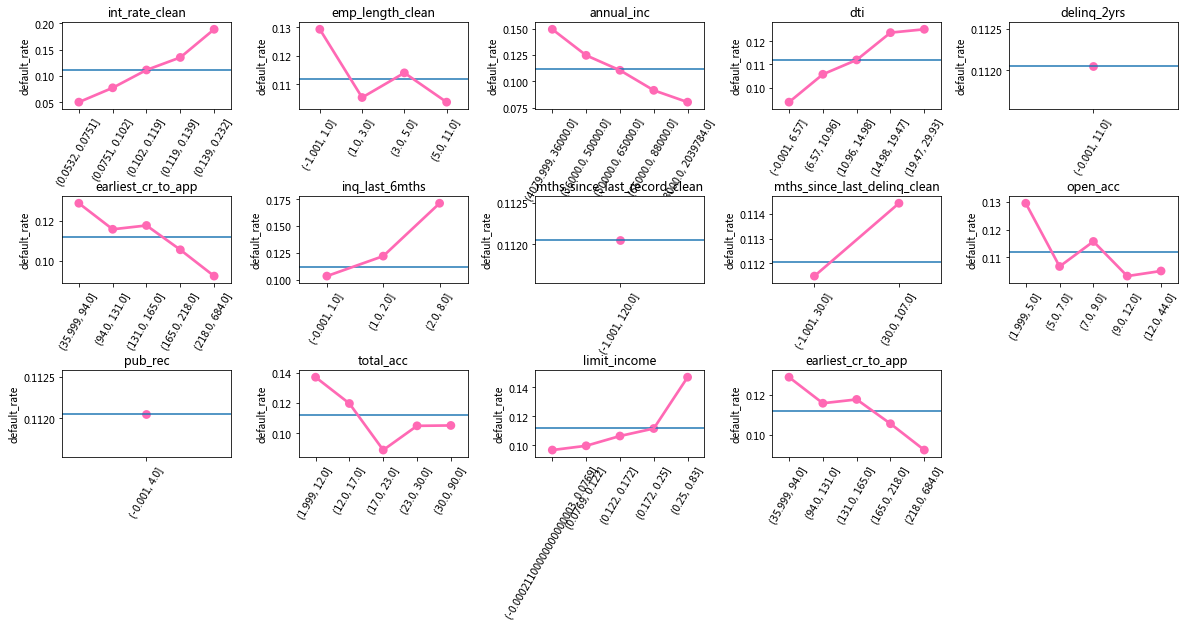

In [41]:
def plot_default_num(df,col_list,target,hspace=0.4,wspace=0.4,q=None,plt_size=None,plt_num=None,x=None,y=None):
    all_bad = df[target].sum()
    total = df[target].count()
    all_default_rate = all_bad*1.0/total 
    
    plt.figure(figsize=plt_size)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    for i,col in zip(range(1,plt_num+1,1),col_list):
        bucket = pd.qcut(df[col],q=q,duplicates='drop')
        d1 = df.groupby(bucket)
        d2 = pd.DataFrame()
        d2['total'] = d1[target].count()
        d2['bad'] = d1[target].sum()
        d2['default_rate'] = d2['bad']/d2['total']
        d2 = d2.reset_index()
        plt.subplot(x,y,i)
        plt.title(col)
        plt.axhline(y=all_default_rate)
        sns.pointplot(data=d2,x=col,y='default_rate',color='hotpink')
        plt.xticks(rotation=60)
        plt.xlabel('')
    return plt.show()
plot_default_num(trainData,num_features,target='y',q=5,hspace=1,wspace=0.4,plt_size=(20,8),plt_num=15,x=3,y=5)

In [95]:
num_features = ['int_rate_clean', 'emp_length_clean', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_to_app',
                'inq_last_6mths', \
                'mths_since_last_record_clean', 'mths_since_last_delinq_clean', 'open_acc', 'pub_rec', 'total_acc',
                'limit_income', 'earliest_cr_to_app']

cat_features = ['home_ownership', 'verification_status', 'desc_clean', 'purpose', 'zip_code', 'addr_state']

In [46]:
def binning_cate(df,col_list,target):
    """
    df:数据集
    col_list:变量list集合
    target:目标变量的字段名
    
    return: 
    bin_df :list形式，里面存储每个变量的分箱结果
    iv_value:list形式，里面存储每个变量的IV值
    """
    total = df[target].count()
    bad = df[target].sum()
    good = total-bad
    all_odds = good*1.0/bad
    bin_df =[]
    iv_value=[]
    for col in col_list:
        d1 = df.groupby([col],as_index=True)
        d2 = pd.DataFrame()
        d2['min_bin'] = d1[col].min()
        d2['max_bin'] = d1[col].max()
        d2['total'] = d1[target].count()
        d2['totalrate'] = d2['total']/total
        d2['bad'] = d1[target].sum()
        d2['badrate'] = d2['bad']/d2['total']
        d2['good'] = d2['total'] - d2['bad']
        d2['goodrate'] = d2['good']/d2['total']
        d2['badattr'] = d2['bad']/bad
        d2['goodattr'] = (d2['total']-d2['bad'])/good
        d2['odds'] = d2['good']/d2['bad']
        GB_list=[]
        for i in d2.odds:
            if i>=all_odds:
                GB_index = str(round((i/all_odds)*100,0))+str('G')
            else:
                GB_index = str(round((all_odds/i)*100,0))+str('B')
            GB_list.append(GB_index)
        d2['GB_index'] = GB_list
        d2['woe'] = np.log(d2['badattr']/d2['goodattr'])
        d2['bin_iv'] = (d2['badattr']-d2['goodattr'])*d2['woe']
        d2['IV'] = d2['bin_iv'].sum()
        iv = d2['bin_iv'].sum().round(3)
        print('变量名:{}'.format(col))
        print('IV:{}'.format(iv))
        print('\t')
        bin_df.append(d2)
        iv_value.append(iv)
    return bin_df,iv_value

member_id                                int64
loan_amnt                                int64
term                                     int64
loan_status                             object
int_rate                                object
emp_length                              object
home_ownership                          object
annual_inc                             float64
verification_status                     object
purpose                                 object
title                                   object
zip_code                                object
addr_state                              object
dti                                    float64
delinq_2yrs                              int64
inq_last_6mths                           int64
open_acc                                 int64
pub_rec                                  int64
total_acc                                int64
pub_rec_bankruptcies                   float64
issue_d                                 object
earliest_cr_l

In [127]:
cat_features = ['home_ownership', 'verification_status', 'desc_clean', 'purpose']

In [128]:
#类别型变量分箱
bin_df_cat,iv_value=sc.binning_cate(trainData_,cat_features,'y')

变量名:home_ownership
IV:0.019
	
变量名:verification_status
IV:0.001
	
变量名:desc_clean
IV:0.003
	
变量名:purpose
IV:0.081
	


In [129]:
bin_df_cat[0]

,min_bin,max_bin,total,totalrate,bad,badrate,good,goodrate,badattr,goodattr,odds,GB_index,woe,bin_iv,IV
home_ownership,,,,,,,,,,,,,,,
MORTGAGE,MORTGAGE,MORTGAGE,7063,0.413283,683,0.096701,6380,0.903299,0.356658,0.420428,9.341142,118.0G,-0.164497,0.010490,0.019442
OWN,OWN,OWN,1345,0.078701,150,0.111524,1195,0.888476,0.078329,0.078748,7.966667,101.0G,-0.005334,0.000002,0.019442
RENT,RENT,RENT,8632,0.505091,1072,0.124189,7560,0.875811,0.559791,0.498188,7.052239,112.0B,0.116587,0.007182,0.019442
other,other,other,50,0.002926,10,0.200000,40,0.800000,0.005222,0.002636,4.000000,198.0B,0.683637,0.001768,0.019442


In [130]:
# 分类型变量的降基处理
def descending_cate(df,col_list,threshold=None):
    """
    df: 数据集
    col_list:变量list集合
    threshold:降基处理的阈值
    
    return :处理后的数据集
    """
    df2 = df.copy()
    for col in col_list:
        value_series = df[col].value_counts()/df[df[col].notnull()].shape[0]
        small_value = []
        for value_name,value_pct in zip(value_series.index,value_series.values):
            if value_pct<=threshold:
                small_value.append(value_name)
        df2.loc[df2[col].isin(small_value),col]='other'
    return df2
trainData=descending_cate(trainData,['home_ownership'],threshold=0.003)

In [85]:
def BadRateEncoding(df, col, target):
    '''
    :param df: dataframe containing feature and target
    :param col: the feature that needs to be encoded with bad rate, usually categorical type
    :param target: good/bad indicator
    :return: the assigned bad rate to encode the categorical feature
    '''
    regroup = BinBadRate(df, col, target, grantRateIndicator=0)[1]
    br_dict = regroup[[col,'bad_rate']].set_index([col]).to_dict(orient='index')
    for k, v in br_dict.items():
        br_dict[k] = v['bad_rate']
    badRateEnconding = df[col].map(lambda x: br_dict[x])
    return {'encoding':badRateEnconding, 'bad_rate':br_dict}

def BinBadRate(df, col, target, grantRateIndicator=0):
    '''
    :param df: 需要计算好坏比率的数据集
    :param col: 需要计算好坏比率的特征
    :param target: 好坏标签
    :param grantRateIndicator: 1返回总体的坏样本率，0不返回
    :return: 每箱的坏样本率，以及总体的坏样本率（当grantRateIndicator＝＝1时）
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left') # 每箱的坏样本数，总样本数
    regroup.reset_index(level=0, inplace=True)
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis=1) # 加上一列坏样本率
    dicts = dict(zip(regroup[col],regroup['bad_rate'])) # 每箱对应的坏样本率组成的字典
    if grantRateIndicator==0:
        return (dicts, regroup)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    overallRate = B * 1.0 / N
    return (dicts, regroup, overallRate)

In [96]:
# 对zip_code,addr_state进行bad_rate编码
br_encoding_dict = {}
more_value_features=['zip_code','addr_state']
for col in more_value_features:
    br_encoding = BadRateEncoding(trainData, col, 'y')
    trainData[col + '_br_encoding'] = br_encoding['encoding']
    br_encoding_dict[col] = br_encoding['bad_rate']
    num_features.append(col + '_br_encoding')

In [180]:
trainData[['zip_code_br_encoding','addr_state_br_encoding']].head()

,zip_code_br_encoding,addr_state_br_encoding
30845,0.000000,0.058824
26622,0.137500,0.130895
36275,0.169935,0.146988
34050,0.164948,0.130895
27202,0.059603,0.092704


In [101]:
#数值型变量卡方分箱
import score_card as sc
bin_df_num,iv_value_num=sc.binning_num(trainData,'y',num_features,max_bin=5,min_binpct=0.1)

变量名:int_rate_clean
IV:0.2
	
变量名:emp_length_clean
IV:0.021
	
变量名:annual_inc
IV:0.06
	
变量名:dti
IV:0.015
	
变量名:delinq_2yrs
IV:0.008
	
变量名:earliest_cr_to_app
IV:0.03
	
变量名:inq_last_6mths
IV:0.052
	
变量名:mths_since_last_record_clean
IV:0.023
	
变量名:mths_since_last_delinq_clean
IV:0.005
	
变量名:open_acc
IV:0.012
	
变量名:pub_rec
IV:0.023
	
变量名:total_acc
IV:0.019
	
变量名:limit_income
IV:0.03
	
变量名:earliest_cr_to_app
IV:0.03
	
变量名:zip_code_br_encoding
IV:0.223
	
变量名:addr_state_br_encoding
IV:0.042
	


In [181]:
bin_df_num[0]

,min_bin,max_bin,total,totalrate,bad,badrate,good,goodrate,badattr,goodattr,odds,GB_index,woe,bin_iv,IV
int_rate_clean,,,,,,,,,,,,,,,
"(-inf, 0.0692]",0.0542,0.0692,1946,0.113868,84,0.043165,1862,0.956835,0.043864,0.122702,22.166667,280.0G,-1.028658,0.081097,0.199533
"(0.0692, 0.128]",0.0699,0.1284,9977,0.583792,949,0.095119,9028,0.904881,0.495561,0.594926,9.513172,120.0G,-0.182746,0.018158,0.199533
"(0.128, 0.153]",0.1286,0.1533,3584,0.209713,554,0.154576,3030,0.845424,0.289295,0.199671,5.469314,145.0B,0.370779,0.033231,0.199533
"(0.153, 0.179]",0.1537,0.1793,1327,0.077648,261,0.196684,1066,0.803316,0.136292,0.070247,4.084291,194.0B,0.662784,0.043774,0.199533
"(0.179, inf]",0.1799,0.2322,256,0.014980,67,0.261719,189,0.738281,0.034987,0.012455,2.820896,281.0B,1.032877,0.023273,0.199533


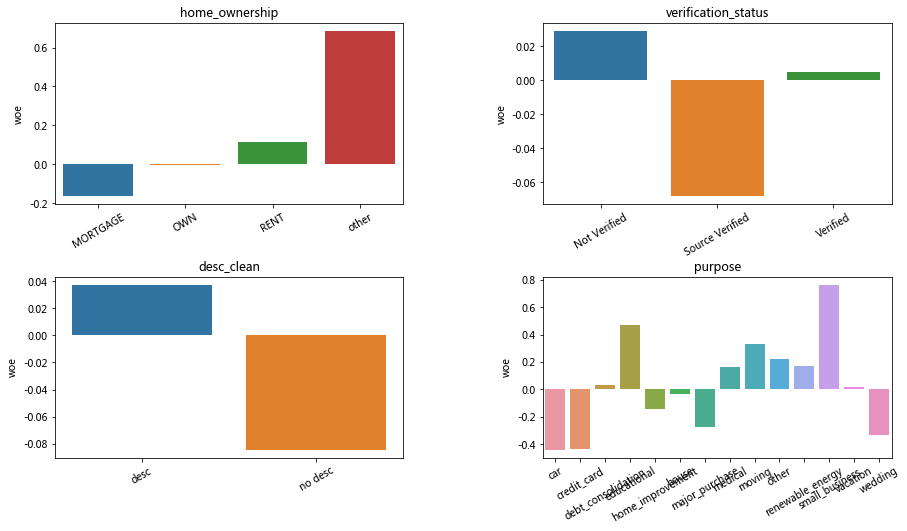

In [105]:
# woe的可视化
def plot_woe(bin_df,hspace=0.4,wspace=0.4,plt_size=None,plt_num=None,x=None,y=None):
    """
    bin_df:list形式，里面存储每个变量的分箱结果
    hspace :子图之间的间隔(y轴方向)
    wspace :子图之间的间隔(x轴方向)
    plt_size :图纸的尺寸
    plt_num :子图的数量
    x :子图矩阵中一行子图的数量
    y :子图矩阵中一列子图的数量
    
    return :每个变量的woe变化趋势图
    """
    plt.figure(figsize=plt_size)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    for i,df in zip(range(1,plt_num+1,1),bin_df):
        col_name = df.index.name
        df = df.reset_index()
        plt.subplot(x,y,i)
        plt.title(col_name)
        sns.barplot(data=df,x=col_name,y='woe')
        plt.xlabel('')
        plt.xticks(rotation=30)
    return plt.show()
plot_woe(bin_df_cat,hspace=0.4,wspace=0.4,plt_size=(15,8),plt_num=4,x=2,y=2)

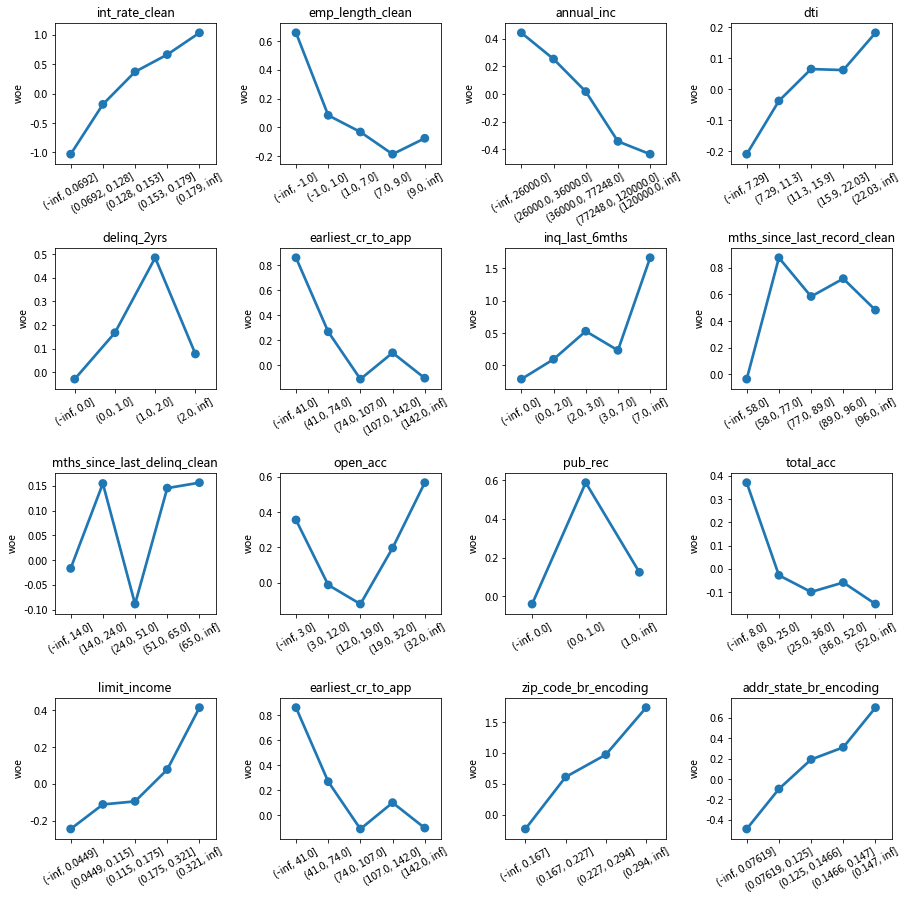

In [109]:
# woe的可视化
def plot_woe(bin_df,hspace=0.4,wspace=0.4,plt_size=None,plt_num=None,x=None,y=None):
    """
    bin_df:list形式，里面存储每个变量的分箱结果
    hspace :子图之间的间隔(y轴方向)
    wspace :子图之间的间隔(x轴方向)
    plt_size :图纸的尺寸
    plt_num :子图的数量
    x :子图矩阵中一行子图的数量
    y :子图矩阵中一列子图的数量
    
    return :每个变量的woe变化趋势图
    """
    plt.figure(figsize=plt_size)
    plt.subplots_adjust(hspace=hspace,wspace=wspace)
    for i,df in zip(range(1,plt_num+1,1),bin_df):
        col_name = df.index.name
        df = df.reset_index()
        plt.subplot(x,y,i)
        plt.title(col_name)
        sns.pointplot(data=df,x=col_name,y='woe')
        plt.xlabel('')
        plt.xticks(rotation=30)
    return plt.show()
plot_woe(bin_df_num,hspace=0.6,wspace=0.4,plt_size=(15,15),plt_num=16,x=4,y=4)

In [111]:
# 检验woe是否单调 
def woe_monoton(bin_df):
    """
    bin_df:list形式，里面存储每个变量的分箱结果
    
    return :
    woe_notmonoton_col :woe没有呈单调变化的变量，list形式
    woe_judge_df :df形式，每个变量的检验结果
    """
    woe_notmonoton_col =[]
    col_list = []
    woe_judge=[]
    for woe_df in bin_df:
        col_name = woe_df.index.name
        woe_list = list(woe_df.woe)
        if woe_df.shape[0]==2:
            #print('{}是否单调: True'.format(col_name))
            col_list.append(col_name)
            woe_judge.append('True')
        else:
            woe_not_monoton = [(woe_list[i]<woe_list[i+1] and woe_list[i]<woe_list[i-1])                                or (woe_list[i]>woe_list[i+1] and woe_list[i]>woe_list[i-1])                                for i in range(1,len(woe_list)-1,1)]
            if True in woe_not_monoton:
                #print('{}是否单调: False'.format(col_name))
                woe_notmonoton_col.append(col_name)
                col_list.append(col_name)
                woe_judge.append('False')
            else:
                #print('{}是否单调: True'.format(col_name))
                col_list.append(col_name)
                woe_judge.append('True')
    woe_judge_df = pd.DataFrame({'col':col_list,
                                 'judge_monoton':woe_judge})
    return woe_notmonoton_col,woe_judge_df
woe_monoton(bin_df_num)

(['emp_length_clean',
  'dti',
  'delinq_2yrs',
  'earliest_cr_to_app',
  'inq_last_6mths',
  'mths_since_last_record_clean',
  'mths_since_last_delinq_clean',
  'open_acc',
  'pub_rec',
  'total_acc',
  'earliest_cr_to_app'],
                              col judge_monoton
 0                 int_rate_clean          True
 1               emp_length_clean         False
 2                     annual_inc          True
 3                            dti         False
 4                    delinq_2yrs         False
 5             earliest_cr_to_app         False
 6                 inq_last_6mths         False
 7   mths_since_last_record_clean         False
 8   mths_since_last_delinq_clean         False
 9                       open_acc         False
 10                       pub_rec         False
 11                     total_acc         False
 12                  limit_income          True
 13            earliest_cr_to_app         False
 14          zip_code_br_encoding          True
 15  

In [131]:
df_woe_cat=sc.woe_df_concat(bin_df_cat)
df_woe_num=sc.woe_df_concat(bin_df_num)

In [136]:
df_woe=pd.concat([df_woe_cat,df_woe_num],axis=0)

In [138]:
# woe转换
def woe_transform(df,target,df_woe):
    """
    df:数据集
    target:目标变量的字段名
    df_woe:woe结果表
    
    return:woe转化之后的数据集
    """
    df2 = df.copy()
    for col in df2.drop([target],axis=1).columns:
        x = df2[col]
        bin_map = df_woe[df_woe.col==col]
        bin_res = np.array([0]*x.shape[0],dtype=float)
        for i in bin_map.index:
            lower = bin_map['min_bin'][i]
            upper = bin_map['max_bin'][i]
            if lower == upper:
                x1 = x.iloc[np.where(x == lower)[0]]
            else:
                x1 = x.iloc[np.where((x>=lower)&(x<=upper))[0]]
            mask = np.in1d(x,x1)
            bin_res[mask] = bin_map['woe'][i]
        bin_res = pd.Series(bin_res,index=x.index)
        bin_res.name = x.name
        df2[col] = bin_res
    return df2

In [184]:
df_woe

,col,bin,min_bin,max_bin,total,totalrate,bad,badrate,good,goodrate,badattr,goodattr,odds,GB_index,woe,bin_iv,IV,score
0,home_ownership,MORTGAGE,MORTGAGE,MORTGAGE,7063,0.413283,683,0.096701,6380,0.903299,0.356658,0.420428,9.341142,118.0G,-0.164497,0.010490,0.019442,-2.0
1,home_ownership,OWN,OWN,OWN,1345,0.078701,150,0.111524,1195,0.888476,0.078329,0.078748,7.966667,101.0G,-0.005334,0.000002,0.019442,-0.0
2,home_ownership,RENT,RENT,RENT,8632,0.505091,1072,0.124189,7560,0.875811,0.559791,0.498188,7.052239,112.0B,0.116587,0.007182,0.019442,1.0
3,home_ownership,other,other,other,50,0.002926,10,0.200000,40,0.800000,0.005222,0.002636,4.000000,198.0B,0.683637,0.001768,0.019442,8.0
4,verification_status,Not Verified,Not Verified,Not Verified,8508,0.497835,978,0.114951,7530,0.885049,0.510705,0.496211,7.699387,103.0B,0.028791,0.000417,0.001500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,addr_state_br_encoding,"(-inf, 0.07619]",0,0.0761905,1003,0.058689,72,0.071785,931,0.928215,0.037598,0.061351,12.930556,163.0G,-0.489661,0.011631,0.042134,-2.0
72,addr_state_br_encoding,"(0.07619, 0.125]",0.0798817,0.125,10831,0.633762,1113,0.102761,9718,0.897239,0.581201,0.640395,8.731357,110.0G,-0.096989,0.005741,0.042134,-0.0
73,addr_state_br_encoding,"(0.125, 0.1466]",0.130895,0.146552,3799,0.222294,504,0.132666,3295,0.867334,0.263185,0.217133,6.537698,121.0B,0.192347,0.008858,0.042134,1.0
74,addr_state_br_encoding,"(0.1466, 0.147]",0.146988,0.146988,1245,0.072850,183,0.146988,1062,0.853012,0.095561,0.069984,5.803279,137.0B,0.311509,0.007968,0.042134,1.0


In [141]:
df_train=woe_transform(trainData,'y',df_woe)

In [140]:
trainData_trans

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,...,desc_clean,app_date_clean,earliest_cr_line_clean,mths_since_last_delinq_clean,mths_since_last_record_clean,pub_rec_bankruptcies_clean,limit_income,earliest_cr_to_app,zip_code_br_encoding,addr_state_br_encoding
30845,0.0,0.0,0.0,0.0,0.0,0.0,-0.005334,0.018223,0.028791,-0.442374,...,0.037037,0.0,0.0,-0.016803,-0.036588,0.0,0.077576,-0.103532,-0.233264,-0.489661
26622,0.0,0.0,0.0,0.0,0.0,0.0,-0.164497,0.018223,0.028791,0.218813,...,-0.084319,0.0,0.0,-0.016803,-0.036588,0.0,-0.112134,-0.103532,-0.233264,0.192347
36275,0.0,0.0,0.0,0.0,0.0,0.0,0.116587,0.253801,0.028791,0.027819,...,0.037037,0.0,0.0,-0.016803,-0.036588,0.0,0.077576,-0.103532,0.610612,0.311509
34050,0.0,0.0,0.0,0.0,0.0,0.0,-0.005334,-0.342301,0.028791,0.162340,...,0.037037,0.0,0.0,-0.016803,-0.036588,0.0,-0.112134,-0.103532,-0.233264,0.192347
27202,0.0,0.0,0.0,0.0,0.0,0.0,-0.164497,0.018223,0.004836,0.027819,...,0.037037,0.0,0.0,-0.016803,-0.036588,0.0,0.077576,-0.103532,-0.233264,-0.096989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36282,0.0,0.0,0.0,0.0,0.0,0.0,-0.164497,0.018223,0.004836,0.027819,...,0.037037,0.0,0.0,-0.016803,-0.036588,0.0,0.414291,-0.111032,-0.233264,-0.096989
31514,0.0,0.0,0.0,0.0,0.0,0.0,0.116587,0.443746,0.028791,0.027819,...,-0.084319,0.0,0.0,-0.016803,-0.036588,0.0,0.414291,0.267416,-0.233264,-0.096989
16670,0.0,0.0,0.0,0.0,0.0,0.0,0.116587,0.018223,0.028791,0.027819,...,-0.084319,0.0,0.0,-0.016803,-0.036588,0.0,0.077576,-0.103532,-0.233264,-0.096989
32019,0.0,0.0,0.0,0.0,0.0,0.0,0.116587,0.018223,0.028791,0.473481,...,0.037037,0.0,0.0,0.154619,-0.036588,0.0,-0.095578,-0.111032,-0.233264,0.192347


In [142]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math

In [278]:
df_train

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,...,int_rate_clean,emp_length_clean,desc_clean,app_date_clean,earliest_cr_line_clean,mths_since_last_delinq_clean,mths_since_last_record_clean,pub_rec_bankruptcies_clean,limit_income,earliest_cr_to_app
3807,0.0,0.0,0.0,0.0,0.0,0.0,-0.161278,0.400707,-0.105210,-0.308814,...,-0.943485,-0.036852,0.005593,0.0,0.0,-0.045741,-0.056129,-0.042024,0.002793,-0.245830
31408,0.0,0.0,0.0,0.0,0.0,0.0,-0.161278,-0.294284,0.022107,-0.129765,...,0.015102,-0.008913,0.005593,0.0,0.0,-0.045741,-0.056129,-0.042024,-0.114214,-0.245830
28683,0.0,0.0,0.0,0.0,0.0,0.0,0.116845,0.020235,0.036070,0.205975,...,0.413621,-0.056262,0.005593,0.0,0.0,-0.045741,-0.056129,-0.042024,0.002793,0.290631
26801,0.0,0.0,0.0,0.0,0.0,0.0,-0.161278,0.020235,-0.105210,0.015965,...,0.413621,-0.008913,-0.012111,0.0,0.0,-0.045741,-0.056129,-0.042024,0.002793,0.043930
6847,0.0,0.0,0.0,0.0,0.0,0.0,0.116845,-0.294284,-0.105210,0.015965,...,0.015102,-0.004994,0.005593,0.0,0.0,-0.045741,-0.056129,-0.042024,0.002793,0.036067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22281,0.0,0.0,0.0,0.0,0.0,0.0,-0.161278,-0.294284,0.022107,0.015965,...,0.413621,-0.008913,-0.012111,0.0,0.0,0.279489,-0.056129,-0.042024,0.297618,-0.148371
17793,0.0,0.0,0.0,0.0,0.0,0.0,-0.161278,0.020235,0.036070,0.015965,...,0.015102,-0.036852,-0.012111,0.0,0.0,0.279489,-0.056129,-0.042024,-0.114214,-0.148371
29805,0.0,0.0,0.0,0.0,0.0,0.0,-0.161278,0.020235,0.036070,-0.129765,...,0.413621,-0.004994,0.005593,0.0,0.0,0.279489,-0.056129,-0.042024,0.002793,0.043930
25180,0.0,0.0,0.0,0.0,0.0,0.0,0.116845,0.020235,-0.105210,0.015965,...,-0.800063,-0.004994,-0.012111,0.0,0.0,-0.045741,-0.056129,-0.042024,0.002793,0.036067


In [143]:
feature_list=num_features+cat_features
x = df_train[feature_list]
y = df_train['y']

lr_model = LogisticRegression(C=0.1)
lr_model.fit(x,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [146]:
df_train['prob'] = lr_model.predict_proba(x)[:,1]

In [145]:
# 评分卡刻度 
def cal_scale(score,odds,PDO,model):
    """
    odds：设定的坏好比
    score:在这个odds下的分数
    PDO: 好坏翻倍比
    model:逻辑回归模型
    
    return :A,B,base_score
    """
    B = PDO/np.log(2)
    A = score+B*np.log(odds)
    # base_score = A+B*model.intercept_[0]
    print('B: {:.2f}'.format(B))
    print('A: {:.2f}'.format(A))
    # print('基础分为：{:.2f}'.format(base_score))
    return A,B
cal_scale(50,0.05,10,lr_model)


B: 14.43
A: 6.78


(6.7807190511263755, 14.426950408889635)

In [147]:
def Prob2Score(prob, A,B):
    #将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    return float(A-B*y)

In [148]:
df_train['score'] = df_train['prob'].map(lambda x:Prob2Score(x,6.78,14.43))

In [153]:
# 变量得分表
def score_df_concat(woe_df,model,B):
    """
    woe_df: woe结果表
    model:逻辑回归模型
    
    return:变量得分结果表
    """
    coe = list(model.coef_[0])
    columns = list(woe_df.col.unique())
    scores=[]
    for c,col in zip(coe,columns):
        score=[]
        for w in list(woe_df[woe_df.col==col].woe):
            s = round(c*w*B,0)
            score.append(s)
        scores.extend(score)
    woe_df['score'] = scores
    score_df = woe_df.copy()
    return score_df
var_score=score_df_concat(df_woe,lr_model,14.43)
var_score.to_excel('var_score.xlsx',index=None)

In [162]:
var_score

,col,bin,min_bin,max_bin,total,totalrate,bad,badrate,good,goodrate,badattr,goodattr,odds,GB_index,woe,bin_iv,IV,score
0,home_ownership,MORTGAGE,MORTGAGE,MORTGAGE,7063,0.413283,683,0.096701,6380,0.903299,0.356658,0.420428,9.341142,118.0G,-0.164497,0.010490,0.019442,-2.0
1,home_ownership,OWN,OWN,OWN,1345,0.078701,150,0.111524,1195,0.888476,0.078329,0.078748,7.966667,101.0G,-0.005334,0.000002,0.019442,-0.0
2,home_ownership,RENT,RENT,RENT,8632,0.505091,1072,0.124189,7560,0.875811,0.559791,0.498188,7.052239,112.0B,0.116587,0.007182,0.019442,1.0
3,home_ownership,other,other,other,50,0.002926,10,0.200000,40,0.800000,0.005222,0.002636,4.000000,198.0B,0.683637,0.001768,0.019442,8.0
4,verification_status,Not Verified,Not Verified,Not Verified,8508,0.497835,978,0.114951,7530,0.885049,0.510705,0.496211,7.699387,103.0B,0.028791,0.000417,0.001500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,addr_state_br_encoding,"(-inf, 0.07619]",0,0.0761905,1003,0.058689,72,0.071785,931,0.928215,0.037598,0.061351,12.930556,163.0G,-0.489661,0.011631,0.042134,-2.0
72,addr_state_br_encoding,"(0.07619, 0.125]",0.0798817,0.125,10831,0.633762,1113,0.102761,9718,0.897239,0.581201,0.640395,8.731357,110.0G,-0.096989,0.005741,0.042134,-0.0
73,addr_state_br_encoding,"(0.125, 0.1466]",0.130895,0.146552,3799,0.222294,504,0.132666,3295,0.867334,0.263185,0.217133,6.537698,121.0B,0.192347,0.008858,0.042134,1.0
74,addr_state_br_encoding,"(0.1466, 0.147]",0.146988,0.146988,1245,0.072850,183,0.146988,1062,0.853012,0.095561,0.069984,5.803279,137.0B,0.311509,0.007968,0.042134,1.0


In [178]:
# 分数转换 
def score_transform(df,target,df_score):
    """
    df:数据集
    target:目标变量的字段名
    df_score:得分结果表
    
    return:得分转化之后的数据集
    """
    df2 = df.copy()
    for col in df2.drop([target],axis=1).columns:
        x = df2[col]
        bin_map = df_score[df_score.col==col]
        bin_res = np.array([0]*x.shape[0],dtype=float)
        for i in bin_map.index:
            lower = bin_map['min_bin'][i]
            upper = bin_map['max_bin'][i]
            if lower == upper:
                x1 = x[np.where(x == lower)[0]]
            else:
                x1 = x[np.where((x>=lower)&(x<=upper))[0]]
            mask = np.in1d(x,x1)
            bin_res[mask] = bin_map['score'][i]
        bin_res = pd.Series(bin_res,index=x.index)
        bin_res.name = x.name
        df2[col] = bin_res
    return df2
df_score=score_transform(trainData,'y',var_score)

In [179]:
df_score.to_excel('df_score.xls',index=None)